# Bank Customer Churn Analysis Project


__Churner__ is generally defined as a customer who stops using a product or service for a given period of time. 



This notebook is to do the data analysis and predictions on the `Churn_Modelling.csv` file.

The first step in the Data Preprocessing is to import the libraries, load the data and do some Exploratory Data Analysis (EDA).

# Project Tasks
## Part 1: Data Loading and Basic Python Operations
1. Import necessary libraries (numpy, pandas, matplotlib, seaborn)
2. Load the dataset using pandas
3. Create functions to:
    ##### Calculate the average balance for different age groups
    ##### Count customers by country using dictionaries


### Importing libraries

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pySankey import sankey
import seaborn as sns
# For the predictive models
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier as GBSklearn
#from xgboost import XGBClassifier as XGB
#import lightgbm as lgb

# Removing annoying warnings
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")


### Defining useful function

In [2]:
def count_by_group(data, feature, target):
    df = data.groupby([feature, target])[target].agg(['count'])
    temp = data.groupby([feature])[target].agg(['count'])
    df['pct'] = 100*df.div(temp, level = feature).reset_index()['count'].values
    return df.reset_index()

def classification_report_to_dataframe(true, predictions, predictions_proba, model_name, balanced = 'no'):
    a = classification_report(true, predictions, output_dict = True)
    zeros = pd.DataFrame(data = a['0'], index = [0]).iloc[:,0:3].add_suffix('_0')
    ones = pd.DataFrame(data = a['1'], index = [0]).iloc[:,0:3].add_suffix('_1')
    df = pd.concat([zeros, ones], axis = 1)
    temp = list(df)
    df['Model'] = model_name
    df['Balanced'] = balanced
    df['Accuracy'] = accuracy_score(true, predictions)
    df['Balanced_Accuracy'] = balanced_accuracy_score(true, predictions)
    df['AUC'] = roc_auc_score(true, predictions_proba, average = 'macro')
    df = df[['Model', 'Balanced', 'Accuracy', 'Balanced_Accuracy', 'AUC'] + temp]
    return df

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

### 2 Load the dataset using pandas


#### The Df has 1000 rows with 14 attributes. We review this further to identify what attributes will be necessary and what data manipulation needs to be carried out before  Exploratory analysis and prediction modelling

In [3]:

data = pd.read_csv('Churn_Modelling.csv', delimiter=',')
data.shape


data.head()
#df.info()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### 3 Create Function to:
#### 3.1. Calculate the average balance for different age groups

In [4]:

def categorize_age_group(Age):
    if Age < 30:
        return 'Young'
    elif Age < 50:
        return 'Middle_aged'
    else:
        return 'Senior'

# Function to calculate the average balance for different age groups
def average_balance_by_age_group(df):
    # Create a new column 'age_group' by applying the categorize_age_group function
    df['AgeGroup'] = df['Age'].apply(categorize_age_group)
    
    # Group by the 'age_group' column and calculate the average balance
    age_group_balance = df.groupby('AgeGroup')['Balance'].mean().round(2)
    
    return age_group_balance
# Convert the data into a pandas DataFrame
df = pd.DataFrame(data)
# Call the function to calculate the average balance by age group
result = average_balance_by_age_group(df)
# Print the result
print(result)


AgeGroup
Middle_aged    76352.77
Senior         80429.11
Young          73698.72
Name: Balance, dtype: float64


### Alternatively Age grouping using pd.cut()

In [5]:

def average_balance_by_age_group_v2(df):
    # Define age bins and labels
    bins = [0, 30, 50, float('inf')]  # Age ranges: <30, <50, >=50
    labels = ['Young', 'Middle_age', 'Senior']
    
    # Create a new 'age_group' column using pd.cut()
    df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)
    
    # Group by the 'age_group' column and calculate the average balance
    age_group_balance = df.groupby('AgeGroup')['Balance'].mean().round(2)
    
    return age_group_balance

# Call the alternative function
result_v2 = average_balance_by_age_group_v2(df)
print(result_v2)

AgeGroup
Young         73698.72
Middle_age    76352.77
Senior        80429.11
Name: Balance, dtype: float64


### 3.2. Count customers by country using dictionaries

In [6]:

df = pd.DataFrame(data)

# Function to count customers by country
def count_customers_by_country(df):
    # Group by the 'country' column and count the number of customers in each country
    country_counts = data['Geography'].value_counts().to_dict()
    return country_counts

# Call the function and print the result
result = count_customers_by_country(df)
print(result)

{'France': 5014, 'Germany': 2509, 'Spain': 2477}


## Part 2: Data Structure Manipulation
1. Create lists of churned and retained customers
2. Use list comprehension to filter high-value customers (balance > 100,000)
3. Create a dictionary with customer statistics by country

#### 1. Create lists of churned and retained customers

In [7]:

df = pd.DataFrame(data)


# Create a list of churned customers
churned_customers = df[df['Exited'] == 1]['Surname'].tolist()

# Create a list of retained customers
retained_customers = df[df['Exited'] == 0]['Surname'].tolist()

# Print the results
print("Churned Customers:", churned_customers[:10])
print("Retained Customers:", retained_customers[:10])


Churned Customers: ['Hargrave', 'Onio', 'Chu', 'Obinna', 'Romeo', 'Gerasimov', 'Azikiwe', 'Lombardo', 'Clarke', 'Lavine']
Retained Customers: ['Hill', 'Boni', 'Mitchell', 'Bartlett', 'He', 'H?', 'Bearce', 'Andrews', 'Kay', 'Chin']


#### 2. Use list comprehension to filter high-value customers (balance > 100,000)

In [8]:

# Convert the data into a pandas DataFrame
df = pd.DataFrame(data)

# Use list comprehension to filter high-value customers with balance > 100,000
high_value_customers = [row['Surname'] for _, row in df.iterrows() if row['Balance'] > 100000]

# Print the result
print("High-Value Customers:", high_value_customers[:15])


High-Value Customers: ['Onio', 'Mitchell', 'Chu', 'Obinna', 'He', 'H?', 'Bearce', 'Goforth', 'Romeo', 'Young', 'McWilliams', 'Sanderson', 'Lombardo', 'Watson', 'Clarke']


### 3. Create a dictionary with customer statistics by country

In [10]:

# Convert the data into a pandas DataFrame
df = pd.DataFrame(data)

# Group by 'country' and aggregate customer statistics
country_stats = {
    country: {
        'customer_count': group.shape[0],
        'average_balance': round(group['Balance'].mean(), 2),
        'active_members': group['IsActiveMember'].sum()
    }
    for country, group in df.groupby('Geography')
}

# Print the dictionary with customer statistics by country
print(country_stats)


{'France': {'customer_count': 5014, 'average_balance': np.float64(62092.64), 'active_members': np.int64(2591)}, 'Germany': {'customer_count': 2509, 'average_balance': np.float64(119730.12), 'active_members': np.int64(1248)}, 'Spain': {'customer_count': 2477, 'average_balance': np.float64(61818.15), 'active_members': np.int64(1312)}}


# Part 3: Data Cleaning and Preparation
1. Check for missing values and handle them appropriately
2. Convert categorical variables to numerical using pandas


### 1. Check for missing values and handle them appropriately

 ### To check for and handle missing values in a pandas DataFrame, follow these steps:

1. Identify missing values using methods like isnull() and sum().
2.  Handle missing values by either:
3.  Removing rows/columns with missing data.
4.  Filling missing values with appropriate values (e.g., mean, median, mode).

In [12]:



# Convert the data into a pandas DataFrame
df = pd.DataFrame(data)

# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

# Handling missing values
# Option 1: Drop rows with any missing values
df_cleaned = df.dropna()

# Option 2: Fill missing values (example: fill 'age' with mean, 'balance' with median)
df_filled = df.copy()
df_filled['Age'].fillna(df['Age'].mean(), inplace=True)
df_filled['Balance'].fillna(df['Balance'].median(), inplace=True)
df_filled['Geography'].fillna('Unknown', inplace=True)
df_filled['IsActiveMember'].fillna(0, inplace=True)  # Assuming 0 for inactive by default

# Print the cleaned DataFrame
print("\nDataFrame after filling missing values:")
print(df_filled)


Missing values in each column:
RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

DataFrame after filling missing values:
      RowNumber  CustomerId    Surname  CreditScore Geography  Gender  Age  \
0             1    15634602   Hargrave          619    France  Female   42   
1             2    15647311       Hill          608     Spain  Female   41   
2             3    15619304       Onio          502    France  Female   42   
3             4    15701354       Boni          699    France  Female   39   
4             5    15737888   Mitchell          850     Spain  Female   43   
...         ...         ...        ...          ...       ...     ...  ...   
9995       9996    15606229   Obijiaku          771    France    Male   39 

### 2. Convert categorical variables to numerical using pandas
#### To convert categorical variables to numerical in a pandas DataFrame
1. Converting categorical data to numerical data is an important step in many data analysis tasks.
2. In Pandas, there are several ways to convert categorical data to numerical data, including the following:



### Using  the LabelEncoder Class 

In [13]:
from sklearn.preprocessing import LabelEncoder

# Create a DataFrame with categorical data
df = pd.DataFrame({'Geography': ['Spain   ', 'France   ', 'Germany   ']})

# Convert categorical data to numerical data using LabelEncoder
le = LabelEncoder()
df['Geography'] = le.fit_transform(df['Geography'])

# View the converted DataFrame
print(df)

   Geography
0          2
1          0
2          1


### Using the replace() Method 

In [14]:
df = pd.DataFrame(data)

# Convert categorical data to numerical data using replace
df['Gender'] = df['Gender'].replace({'Male': 0, 'Female': 1})

# View the converted DataFrame
print(df)

      RowNumber  CustomerId    Surname  CreditScore Geography  Gender  Age  \
0             1    15634602   Hargrave          619    France       1   42   
1             2    15647311       Hill          608     Spain       1   41   
2             3    15619304       Onio          502    France       1   42   
3             4    15701354       Boni          699    France       1   39   
4             5    15737888   Mitchell          850     Spain       1   43   
...         ...         ...        ...          ...       ...     ...  ...   
9995       9996    15606229   Obijiaku          771    France       0   39   
9996       9997    15569892  Johnstone          516    France       0   35   
9997       9998    15584532        Liu          709    France       1   36   
9998       9999    15682355  Sabbatini          772   Germany       0   42   
9999      10000    15628319     Walker          792    France       1   28   

      Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMemb

# Part 4: Exploratory Data Analysis and Visualization
### Create basic plots:
1. Histogram of customer ages
2. Bar plot of churn rate by country
3. Box plot of balance distribution

### 4.1 Histogram of customer ages

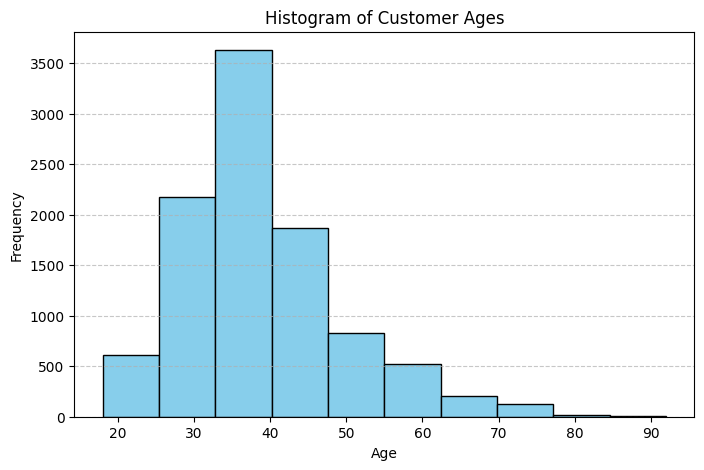

In [15]:


# using matplotlib
df = pd.DataFrame(data)

# Create a histogram for customer ages
plt.figure(figsize=(8, 5))
plt.hist(df['Age'], bins=10, color='skyblue', edgecolor='black')
plt.title('Histogram of Customer Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


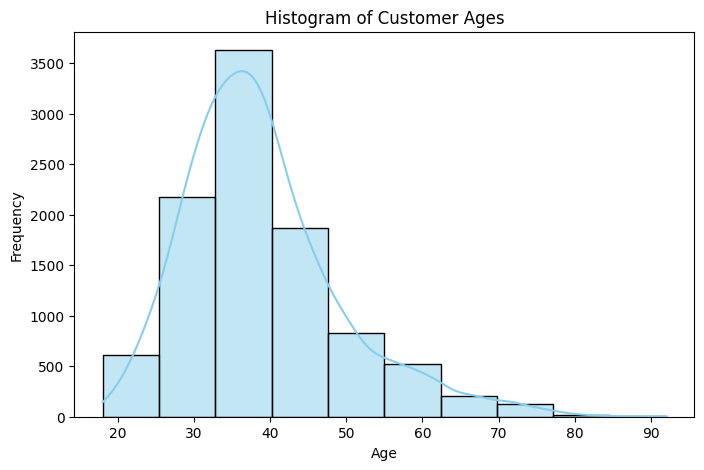

In [16]:
# Using Searbon
plt.figure(figsize=(8, 5))
sns.histplot(df['Age'], bins=10, kde=True, color='skyblue')
plt.title('Histogram of Customer Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Show the plot
plt.show()

### 4.2 Bar plot of churn rate by country

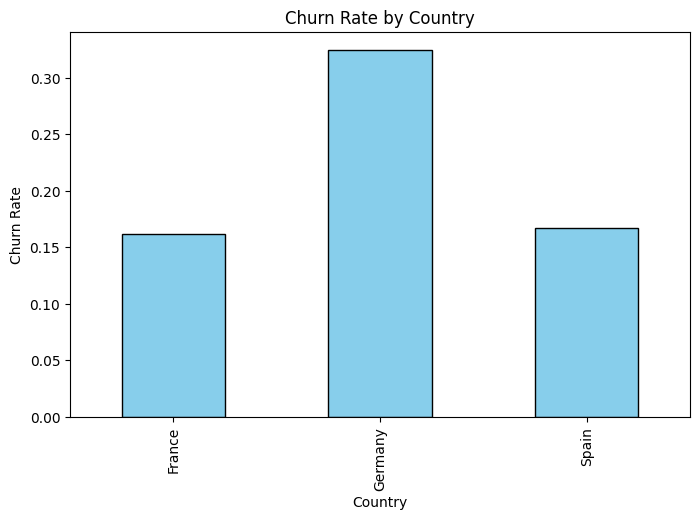

In [17]:

# Convert the data into a pandas DataFrame
df = pd.DataFrame(data)

# Calculate churn rate by country
churn_rate = df.groupby('Geography')['Exited'].mean()

# Create a bar plot for churn rate by country
plt.figure(figsize=(8, 5))
churn_rate.plot(kind='bar', color='skyblue', edgecolor='black')

# Add titles and labels
plt.title('Churn Rate by Country')
plt.xlabel('Country')
plt.ylabel('Churn Rate')

# Show the plot
plt.show()

### 4.3 Box plot of balance distribution

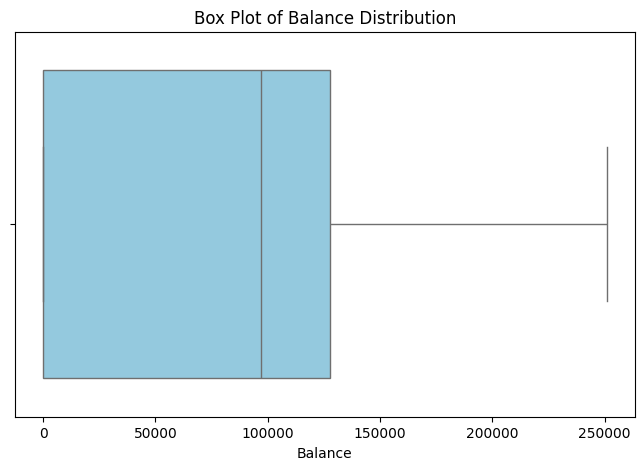

In [20]:

# Usinf searbon 

# Convert the data into a pandas DataFrame
df = pd.DataFrame(data)

# Create a box plot for balance distribution
plt.figure(figsize=(8, 5))
sns.boxplot(x=df['Balance'], color='skyblue')

# Add titles and labels
plt.title('Box Plot of Balance Distribution')
plt.xlabel('Balance')

# Show the plot
plt.show()

### Proportion of customer churned and retained

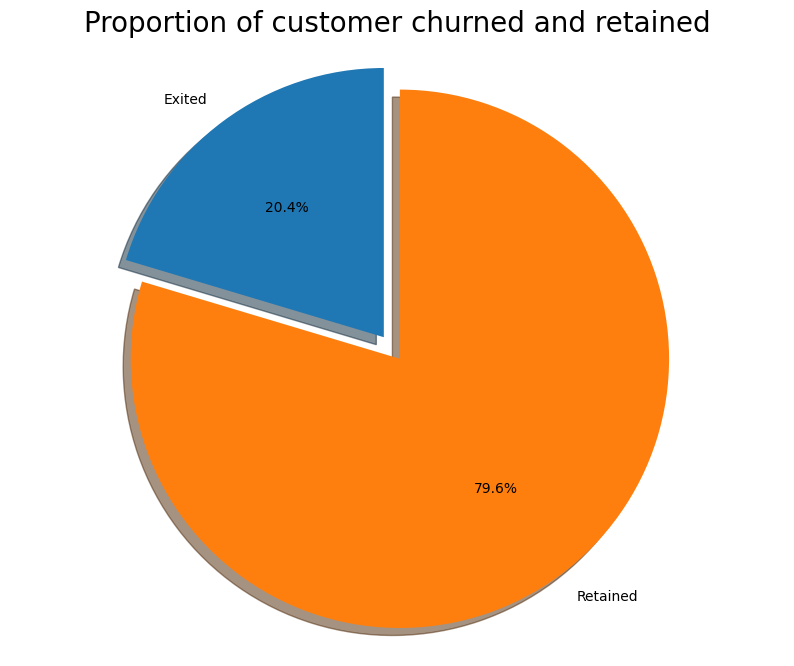

In [21]:
labels = 'Exited', 'Retained'
sizes = [df.Exited[df['Exited']==1].count(), df.Exited[df['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of customer churned and retained", size = 20)
plt.show()


In [22]:
def create_visualizations(df):
    # Set up the matplotlib figure
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Age distribution
    sns.histplot(data=df, x='age', hue='churn', multiple="stack", ax=axes[0, 0])
    axes[0, 0].set_title('Age Distribution by Churn Status')

    # Balance by product number
    sns.boxplot(data=df, x='products_number', y='balance', ax=axes[0, 1])
    axes[0, 1].set_title('Balance Distribution by Product Number')

    # Correlation heatmap
    numeric_cols = ['age', 'balance', 'credit_score', 'tenure']
    sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', ax=axes[1, 0])
    axes[1, 0].set_title('Correlation Heatmap')

    # Churn rate by credit score range
    sns.barplot(data=df, x='credit_score_range', y='churn', ax=axes[1, 1])
    axes[1, 1].set_title('Churn Rate by Credit Score Range')

    plt.tight_layout()  # Adjust layout to prevent overlapping
    return fig
plt.show()


### 1. Age Distribution by Churn Status
This plot shows how the ages of customers differ between those who churned and those who didn’t.

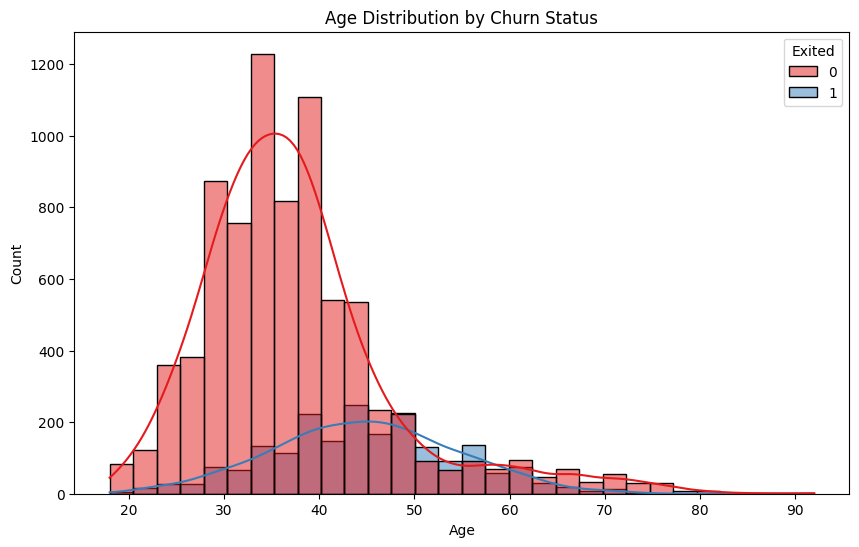

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='Age', hue='Exited', kde=True, bins=30, palette='Set1')
plt.title('Age Distribution by Churn Status')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

### 2. Balance Distribution by Churn Status
A boxplot to compare the distribution of account balances for churned vs. non-churned customers.

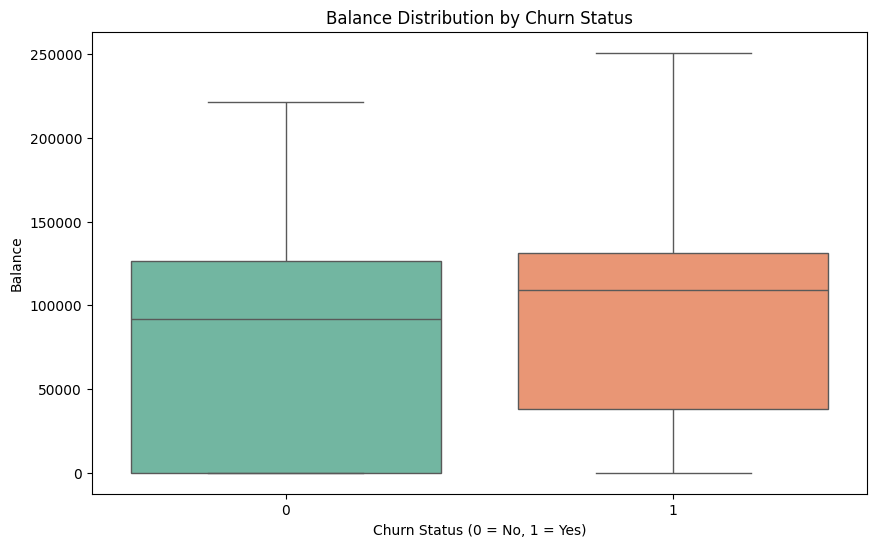

In [24]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='Exited', y='Balance', palette='Set2')
plt.title('Balance Distribution by Churn Status')
plt.xlabel('Churn Status (0 = No, 1 = Yes)')
plt.ylabel('Balance')
plt.show()

## 3. Correlation Heatmap
Visualize the relationships between numerical features to identify which ones are correlated.

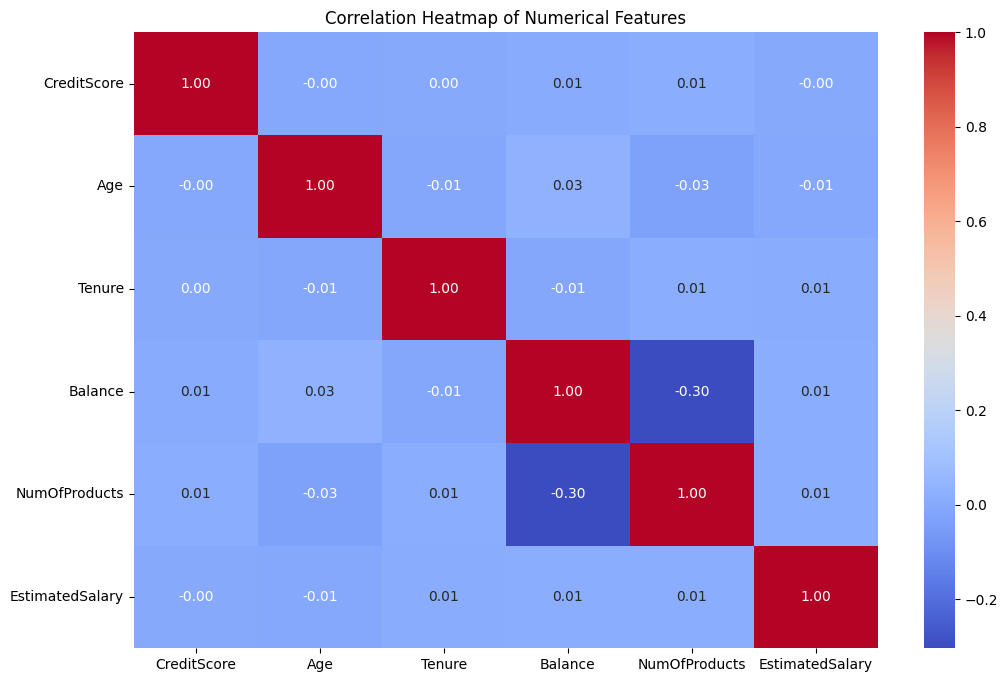

In [25]:
plt.figure(figsize=(12, 8))
numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
sns.heatmap(data[numeric_features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

### 4. Churn Rate by Geography
A barplot showing churn rates across different regions.

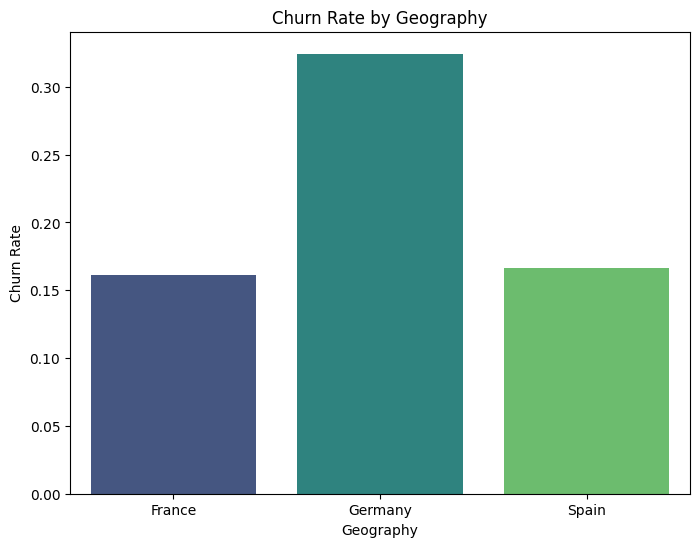

In [26]:
geo_churn = data.groupby('Geography').Exited.mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(data=geo_churn, x='Geography', y='Exited', palette='viridis')
plt.title('Churn Rate by Geography')
plt.xlabel('Geography')
plt.ylabel('Churn Rate')
plt.show()

In [27]:
print(data.columns)

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')


### 5. Credit Score Distribution Across Product Numbers 
Compare how credit scores are distributed for customers with different numbers of products.

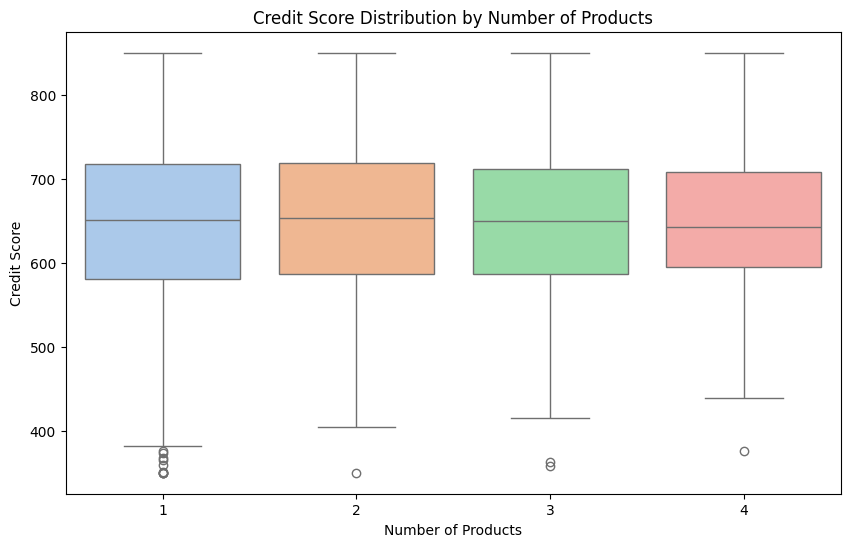

In [28]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='NumOfProducts', y='CreditScore', palette='pastel')
plt.title('Credit Score Distribution by Number of Products')
plt.xlabel('Number of Products')
plt.ylabel('Credit Score')
plt.show()

# Part 5: Basic Predictive Analysis
1. Prepare features for modeling
2. Split data into training and testing sets
3. Create a simple prediction model using the following features: Credit score, Age, Balance, Number of products, Active member status


### 1. Preparing features for modeling

In [29]:

# 1. Data Cleaning

# Checking if there is any missing data in the dataset:
data.isna().sum()

# The dataset has no missing values.

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [30]:
# Remove duplicate

df.drop_duplicates(inplace=True)
# Get unique count for each variable
df.nunique()
# round(data.describe(),3)

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

In [31]:
#  statistical summary of the DataFrame
round(data.describe(),3)

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000,1.000000e+04,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000
mean,5000.500,1.569094e+07,650.529,38.922,5.013,76485.889,1.530,0.706,0.515,100090.240,0.204
std,2886.896,7.193619e+04,96.653,10.488,2.892,62397.405,0.582,0.456,0.500,57510.493,0.403
min,1.000,1.556570e+07,350.000,18.000,0.000,0.000,1.000,0.000,0.000,11.580,0.000
25%,2500.750,1.562853e+07,584.000,32.000,3.000,0.000,1.000,0.000,0.000,51002.110,0.000
50%,5000.500,1.569074e+07,652.000,37.000,5.000,97198.540,1.000,1.000,1.000,100193.915,0.000
75%,7500.250,1.575323e+07,718.000,44.000,7.000,127644.240,2.000,1.000,1.000,149388.248,0.000
max,10000.000,1.581569e+07,850.000,92.000,10.000,250898.090,4.000,1.000,1.000,199992.480,1.000


In [32]:
# #Computing the number of exited and not exited clients:

exited = len(data[data['Exited'] == 1]['Exited'])
not_exited = len(data[data['Exited'] == 0]['Exited'])
exited_perc = round(exited/len(data)*100,1)
not_exited_perc = round(not_exited/len(data)*100,1)
print('Number of clients that have leave the bank service: {} ({}%)'.format(exited, exited_perc))
print('Number of clients that haven\'t exited the bank: {} ({}%)'.format(not_exited, not_exited_perc))



Number of clients that have leave the bank service: 2037 (20.4%)
Number of clients that haven't exited the bank: 7963 (79.6%)


So, around of 20% of the clients exited the bank, while around 80% stayed. As the goal here is to identify which of the customers are at higher risk to discontinue their services with the bank, we are dealing with a classification problem.

A important point to take into consideration here is that we are dealing with an __imbalanced dataset__.

In [33]:

# A important point to take into consideration here is that we are dealing with an imbalanced dataset.

country = list(data['Geography'].unique())
gender = list(data['Gender'].unique())

print(country)
print(gender)



['France', 'Spain', 'Germany']
['Female', 'Male']


In [34]:
# Create a Exited string variable to create the plots
data['Exited_str'] = data['Exited']
data['Exited_str'] = data['Exited_str'].map({1: 'Exited', 0: 'Stayed'})

In [35]:
gender_count = data['Gender'].value_counts()
gender_pct= gender_count / len(data.index)

gender = pd.concat([gender_count, round(gender_pct,2)], axis=1)\
        .set_axis(['count', 'pct'], axis=1)
gender

,count,pct
Gender,,
Male,5457,0.55
Female,4543,0.45


In [37]:
geo_count = data['Geography'].value_counts()
geo_pct= geo_count / len(data.index)

geo = pd.concat([geo_count, round(geo_pct,2)], axis=1)\
        .set_axis(['count', 'pct'], axis=1)
geo




,count,pct
Geography,,
France,5014,0.50
Germany,2509,0.25
Spain,2477,0.25


 In the dataset, there are more men (55%) than women (45%), and it has only 3 different countries: France, Spain, and Germany. Where 50% of the customers are from France and  25% are from Germany, and the other group are from Spain.

In [38]:
# Now, let's just check the relationship between the features and the outcome ('Exited').
def count_by_group(data, feature, target):
    df = data.groupby([feature, target])[target].agg(['count'])
    temp = data.groupby([feature])[target].agg(['count'])
    df['pct'] = 100*df.div(temp, level = feature).reset_index()['count'].values
    return df.reset_index()

In [39]:
count_by_group(data, feature = 'Gender', target = 'Exited')

,Gender,Exited,count,pct
0,Female,0,3404,74.928461
1,Female,1,1139,25.071539
2,Male,0,4559,83.544072
3,Male,1,898,16.455928


In [40]:
features = list(data.drop('Exited', axis = 1))
target = 'Exited'

In [41]:
import plotly.graph_objects as go
data=pd.read_csv('Churn_Modelling.csv')
data['Exited_str'] = data['Exited'].map({1: 'Exited', 0: 'Stayed'})

# Define color dictionary
colorDict = {
    'Exited': '#f71b1b',
    'Stayed': 'grey',
    'Female': '#FFD700',
    'Male': '#8E388E'
}

# Define nodes for the Sankey diagram
node_labels = ['Male', 'Female', 'Stayed', 'Exited']
node_colors = [colorDict[label] for label in node_labels]
node_dict = {label: index for index, label in enumerate(node_labels)}

# Create links (flows) by counting combinations of Gender and Exited_str
flows = data.groupby(['Gender', 'Exited_str']).size().reset_index(name='count')

# Define sources, targets, and values based on flows
sources = flows['Gender'].map(node_dict).tolist()      # Convert 'Gender' to node index
targets = flows['Exited_str'].map(node_dict).tolist()   # Convert 'Exited_str' to node index
values = flows['count'].tolist()                        # Flow values (counts)

# Create the Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=node_labels,
        color=node_colors
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color=[colorDict['Stayed'] if target == node_dict['Stayed'] else colorDict['Exited'] for target in targets]
    )
))

# Customize layout
fig.update_layout(
    title_text="Gender-based Retention and Exit Flow",
    font_size=12
)

fig.show()

In [42]:
count_by_group(data, feature = 'Geography', target = 'Exited')

,Geography,Exited,count,pct
0,France,0,4204,83.845233
1,France,1,810,16.154767
2,Germany,0,1695,67.556796
3,Germany,1,814,32.443204
4,Spain,0,2064,83.326605
5,Spain,1,413,16.673395


In [43]:
HasCrCard_count = data['HasCrCard'].value_counts()
HasCrCard_pct= HasCrCard_count / len(data.index)

HasCrCard = pd.concat([HasCrCard_count, HasCrCard_pct], axis=1)\
        .set_axis(['count', 'pct'], axis=1)

HasCrCard

,count,pct
HasCrCard,,
1,7055,0.7055
0,2945,0.2945


In [44]:
data['HasCrCard_str'] = data['HasCrCard'].map({1: 'Has Credit Card', 0: 'Does not have Credit Card'})

# Map 'Exited' column to readable strings
data['Exited_str'] = data['Exited'].map({1: 'Exited', 0: 'Stayed'})

# Define color dictionary
colorDict = {
    'Exited': '#f71b1b',
    'Stayed': 'grey',
    'Has Credit Card': '#FFD700',
    'Does not have Credit Card': '#8E388E'
}

# Define nodes for the Sankey diagram
node_labels = ['Has Credit Card', 'Does not have Credit Card', 'Stayed', 'Exited']
node_colors = [colorDict[label] for label in node_labels]
node_dict = {label: index for index, label in enumerate(node_labels)}

# Create links (flows) by counting combinations of HasCrCard_str and Exited_str
flows = data.groupby(['HasCrCard_str', 'Exited_str']).size().reset_index(name='count')

# Define sources, targets, and values based on flows
sources = flows['HasCrCard_str'].map(node_dict).tolist()  # Convert 'HasCrCard_str' to node index
targets = flows['Exited_str'].map(node_dict).tolist()     # Convert 'Exited_str' to node index
values = flows['count'].tolist()                          # Flow values (counts)

# Create the Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=node_labels,
        color=node_colors
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color=[colorDict['Stayed'] if target == node_dict['Stayed'] else colorDict['Exited'] for target in targets]
    )
))

# Customize layout
fig.update_layout(
    title_text="Credit Card Ownership and Customer Retention",
    font_size=12
)

fig.show()

In [45]:
IsActiveMember_count = data['IsActiveMember'].value_counts()
IsActiveMember_pct= HasCrCard_count / len(data.index)

IsActiveMember = pd.concat([IsActiveMember_count, IsActiveMember_pct], axis=1)\
        .set_axis(['count', 'pct'], axis=1)

IsActiveMember

,count,pct
1,5151,0.7055
0,4849,0.2945


In [46]:
count_by_group(data, feature = 'IsActiveMember', target = 'Exited')

,IsActiveMember,Exited,count,pct
0,0,0,3547,73.149103
1,0,1,1302,26.850897
2,1,0,4416,85.730926
3,1,1,735,14.269074


In [47]:
data['IsActiveMember_str'] = data['IsActiveMember'].map({1: 'Is Active Member', 0: 'Is Not ActiveMember'})
data['Exited_str'] = data['Exited'].map({1: 'Exited', 0: 'Stayed'})

# Create the Sankey diagram
colorDict = {
    'Exited': '#f71b1b',
    'Stayed': 'grey',
    'Is Active Member': '#FFD700',
    'Is Not ActiveMember': '#8E388E'
}

# Prepare the nodes and links for the Sankey chart
labels = ['Is Active Member', 'Is Not ActiveMember', 'Exited', 'Stayed']
source = []
target = []
values = []

# Calculate the counts of combinations between 'IsActiveMember_str' and 'Exited_str'
for source_label in ['Is Active Member', 'Is Not ActiveMember']:
    for target_label in ['Exited', 'Stayed']:
        count = len(data[(data['IsActiveMember_str'] == source_label) & (data['Exited_str'] == target_label)])
        if count > 0:
            source.append(labels.index(source_label))
            target.append(labels.index(target_label))
            values.append(count)

# Create Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=[colorDict[label] for label in labels]  # Apply colors from the colorDict
    ),
    link=dict(
        source=source,
        target=target,
        value=values,
        color=[colorDict[labels[target[i]]] for i in range(len(target))]  # Color links based on target
    )
))

# Update layout for better aesthetics
fig.update_layout(
    title_text="Sankey Diagram: Is Active Member vs Exited",
    font_size=12,
    width=800,
    height=600
)

# Show the plot
fig.show()

In [48]:
NumOfProducts_count = data['NumOfProducts'].value_counts()
NumOfProducts_pct= NumOfProducts_count / len(data.index)

NumOfProducts = pd.concat([NumOfProducts_count, round(NumOfProducts_pct,2)], axis=1)\
        .set_axis(['count', 'pct'], axis=1)
NumOfProducts

,count,pct
NumOfProducts,,
1,5084,0.51
2,4590,0.46
3,266,0.03
4,60,0.01


In [49]:
count_by_group(data, feature = 'NumOfProducts', target = 'Exited')

,NumOfProducts,Exited,count,pct
0,1,0,3675,72.285602
1,1,1,1409,27.714398
2,2,0,4242,92.418301
3,2,1,348,7.581699
4,3,0,46,17.293233
5,3,1,220,82.706767
6,4,1,60,100.000000


In [50]:
data['NumOfProducts_str'] = data['NumOfProducts'].map({1: '1', 2: '2', 3: '3', 4: '4'})
data['Exited_str'] = data['Exited'].map({1: 'Exited', 0: 'Stayed'})

# Define color dictionary
colorDict = {
    'Exited': '#f71b1b',
    'Stayed': 'grey',
    '1': '#f3f71b',
    '2': '#12e23f',
    '3': '#f78c1b',
    '4': '#8E388E'
}

# Prepare the nodes and links for the Sankey chart
labels = ['1', '2', '3', '4', 'Exited', 'Stayed']
source = []
target = []
values = []

# Calculate the counts of combinations between 'NumOfProducts_str' and 'Exited_str'
for product in ['1', '2', '3', '4']:
    for status in ['Exited', 'Stayed']:
        count = len(data[(data['NumOfProducts_str'] == product) & (data['Exited_str'] == status)])
        if count > 0:
            source.append(labels.index(product))
            target.append(labels.index(status))
            values.append(count)

# Create Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=[colorDict[label] for label in labels]  # Apply colors from the colorDict
    ),
    link=dict(
        source=source,
        target=target,
        value=values,
        color=[colorDict[labels[target[i]]] for i in range(len(target))]  # Color links based on target
    )
))

# Update layout for better aesthetics
fig.update_layout(
    title_text="Sankey Diagram: Number of Products vs Exited",
    font_size=12,
    width=800,
    height=600
)

# Show the plot
fig.show()

### Stacked histogram: Age


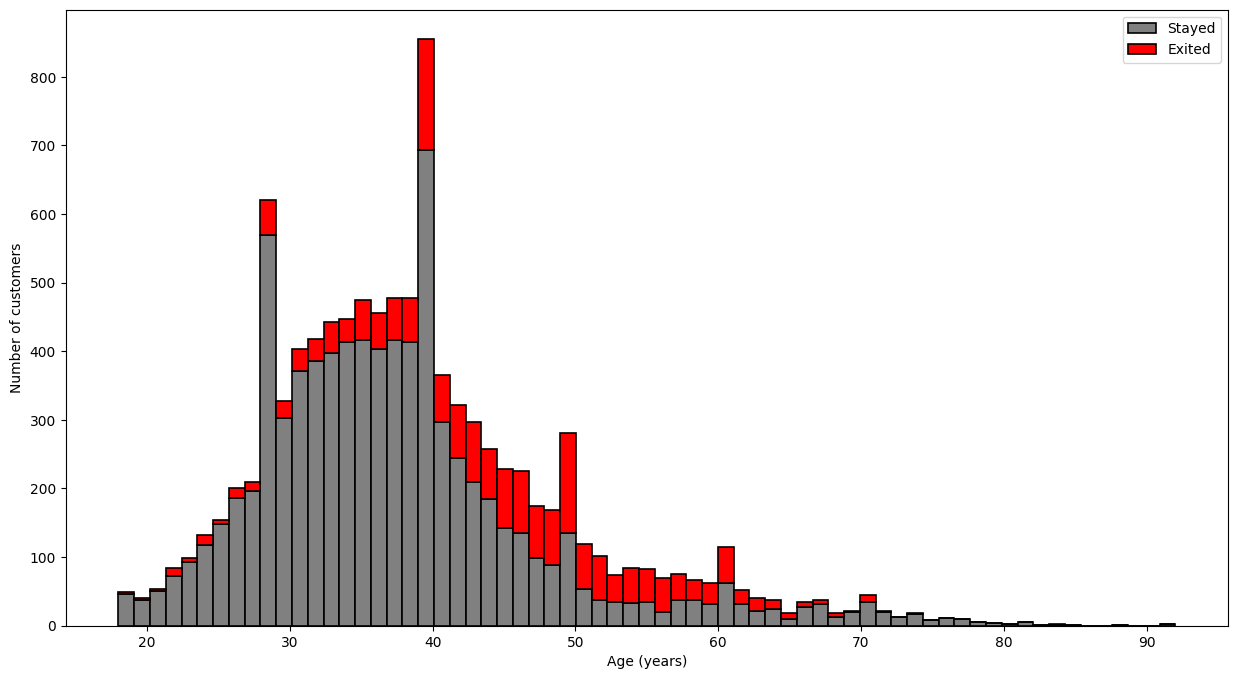

In [51]:
figure = plt.figure(figsize=(15,8))
plt.hist([
        data[(data.Exited==0)]['Age'],
        data[(data.Exited==1)]['Age']
        ], 
         stacked=True, color = ['grey','r'],
         bins = 'auto',label = ['Stayed','Exited'],
         edgecolor='black', linewidth=1.2)
plt.xlabel('Age (years)')
plt.ylabel('Number of customers')
plt.legend()

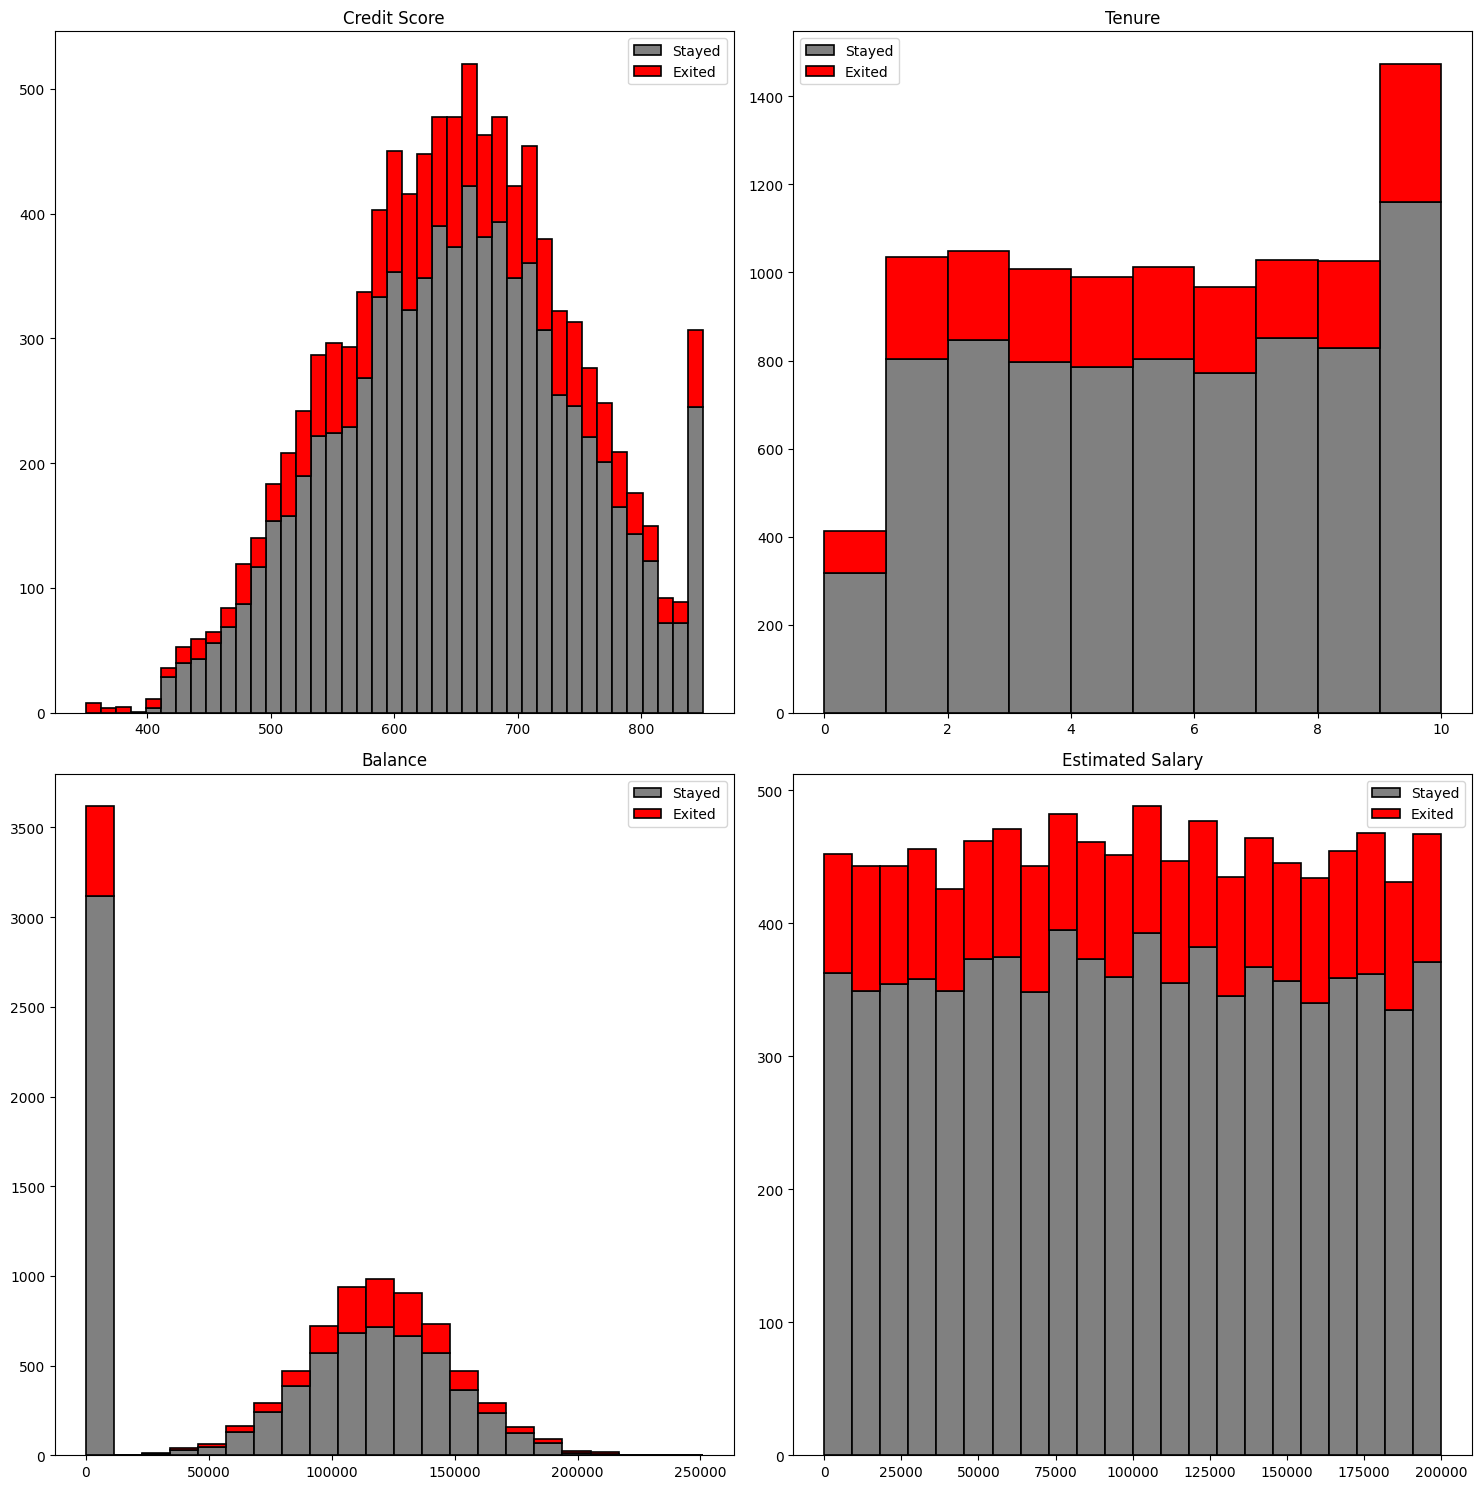

In [52]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (15,15))
fig.subplots_adjust(left=0.2, wspace=0.6)
ax0, ax1, ax2, ax3 = axes.flatten()

ax0.hist([
        data[(data.Exited==0)]['CreditScore'],
        data[(data.Exited==1)]['CreditScore']
        ], 
         stacked=True, color = ['grey','r'],
         bins = 'auto',label = ['Stayed','Exited'],
         edgecolor='black', linewidth=1.2)
ax0.legend()
ax0.set_title('Credit Score')

ax1.hist([
        data[(data.Exited==0)]['Tenure'],
        data[(data.Exited==1)]['Tenure']
        ], 
         stacked=True, color = ['grey','r'],
         bins = 'auto',label = ['Stayed','Exited'],
         edgecolor='black', linewidth=1.2)
ax1.legend()
ax1.set_title('Tenure')

ax2.hist([
        data[(data.Exited==0)]['Balance'],
        data[(data.Exited==1)]['Balance']
        ], 
         stacked=True, color = ['grey','r'],
         bins = 'auto',label = ['Stayed','Exited'],
         edgecolor='black', linewidth=1.2)
ax2.legend()
ax2.set_title('Balance')

ax3.hist([
        data[(data.Exited==0)]['EstimatedSalary'],
        data[(data.Exited==1)]['EstimatedSalary']
        ], 
         stacked=True, color = ['grey','r'],
         bins = 'auto',label = ['Stayed','Exited'],
         edgecolor='black', linewidth=1.2)
ax3.legend()
ax3.set_title('Estimated Salary')

fig.tight_layout()
plt.show()

### From the tables and plots above, we can have some insights:

1. As for gender, women are lower in number than the men, but have a higher rate to close the account.
2. There is a higher rate of exited clients in Germany (32%, which is about 2x higher), and lower in Spain and France (around 16% each).
3. On age, customer bellow 40 and above 65 years old have a tendency to keep their account.
4. Has or not credit card does not impact on the decision to stay in the bank (both groups has 20% of exited customers)
5. Non active members tend to discontinue their services with a bank compared with the active clients (27% vs 14%). 
6. The dataset has 96% of clients  with 1 or 2 product, and customers with 1 product only have a higher rate to to close the account than those with 2 products (around 3x higher).
7. Estimated Salary does not seem to affect the churn rate

### 2 Splitting the dataset into the Training set and Test set

In [53]:

# Now, let's split the data intro train and test sets (80% and 20%, respectively).
train, test = train_test_split(data, test_size = 0.2, random_state = 1)

print('Number of clients in the dataset: {}'.format(len(data)))
print('Number of clients in the train set: {}'.format(len(train)))
print('Number of clients in the test set: {}'.format(len(test)))


Number of clients in the dataset: 10000
Number of clients in the train set: 8000
Number of clients in the test set: 2000


In [54]:
exited_train = len(train[train['Exited'] == 1]['Exited'])
exited_train_perc = round(exited_train/len(train)*100,1)

exited_test = len(test[test['Exited'] == 1]['Exited'])
exited_test_perc = round(exited_test/len(test)*100,1)

print('Complete Train set - Number of clients that have exited the bank: {} ({}%)'.format(exited_train, exited_train_perc))

print('Test set - Number of clients that haven\'t exited the bank: {} ({}%)'.format(exited_test, exited_test_perc))

Complete Train set - Number of clients that have exited the bank: 1622 (20.3%)
Test set - Number of clients that haven't exited the bank: 415 (20.8%)


8000
2000


(-1.0, 5.0)

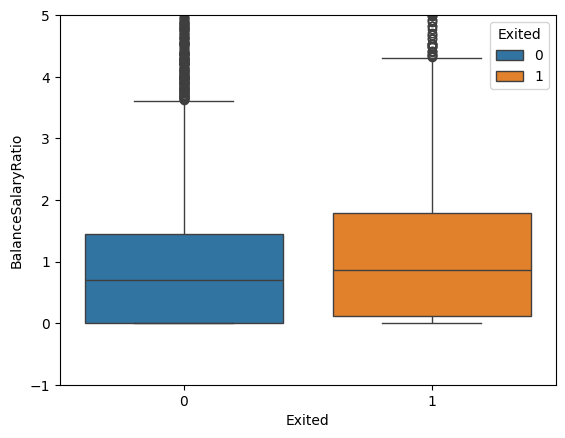

In [55]:
df_train = df.sample(frac=0.8,random_state=200)
df_test = df.drop(df_train.index)
print(len(df_train))
print(len(df_test))

df_train['BalanceSalaryRatio'] = df_train.Balance/df_train.EstimatedSalary
sns.boxplot(y='BalanceSalaryRatio',x = 'Exited', hue = 'Exited',data = df_train)
plt.ylim(-1, 5)

### Feature Scaling

The data contain features in different order of magnitude. Tree based models can handle this kind of data without any normalization, but *logistic regression* and *neural networks* (MLP) require the normalization of the data for a better performance.

In [ ]:
sc = StandardScaler()

# fit on training set
train[features] = sc.fit_transform(train[features])

# only transform on test set
test[features] = sc.transform(test[features])

####  Logistic Regression (Sklearn) 

For the first prediction, let's use the Sklearn Logistic Regression searching for the best parameters using the  Grid Search CV function:

In [196]:
data['Gender'] = LabelEncoder().fit_transform(data['Gender'])  # Encode Gender (Male=1, Female=0)
data = pd.get_dummies(data, columns=['Geography'], drop_first=True)  # One-hot encode 'Geography'

# Define feature columns and target column
features = ['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
            'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain']
target = 'Exited'

# Split into train and test sets
train, test = train_test_split(data, test_size=0.2, random_state=42)

# Parameters for Logistic Regression
parameters = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [50, 100, 150]
}

# Define Logistic Regression model
LR = LogisticRegression(penalty='l2')

# Use GridSearchCV for hyperparameter tuning
model_LR = GridSearchCV(LR, parameters, cv=5, n_jobs=10, verbose=1)

# Fit the model
model_LR.fit(train[features], train[target])

# Convert the results to a DataFrame for better readability
results_df = pd.DataFrame(model_LR.cv_results_)

# Display the top rows of the results
print(results_df.head())

# Display the best parameters and score
print("Best Parameters:", model_LR.best_params_)
print("Best Cross-Validation Score:", model_LR.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_C  \
0       1.972984      0.022655         0.006044        0.003253     0.01   
1       0.188509      0.023618         0.007369        0.004958     0.01   
2       0.184684      0.025663         0.004208        0.000742     0.01   
3       1.136815      0.057985         0.004048        0.001918     0.01   
4       0.345827      0.027145         0.031636        0.034328     0.01   

   param_max_iter param_solver  \
0              50    newton-cg   
1              50        lbfgs   
2              50    liblinear   
3              50          sag   
4              50         saga   

                                              params  split0_test_score  \
0  {'C': 0.01, 'max_iter': 50, 'solver': 'newton-...           0.795625   
1     {'C': 0.01, 'max_iter': 50, 'solver': 'lbfgs'}           0.793125   
2  {'C': 0.01, 'max_iter': 50, 'solver': 'libline..

In [197]:
print(model_LR.best_params_)

{'C': 10, 'max_iter': 150, 'solver': 'newton-cg'}


Now that we know the "best" parameters for the model, let's do a *Recursive Feature Elimination* to check the feature importance.

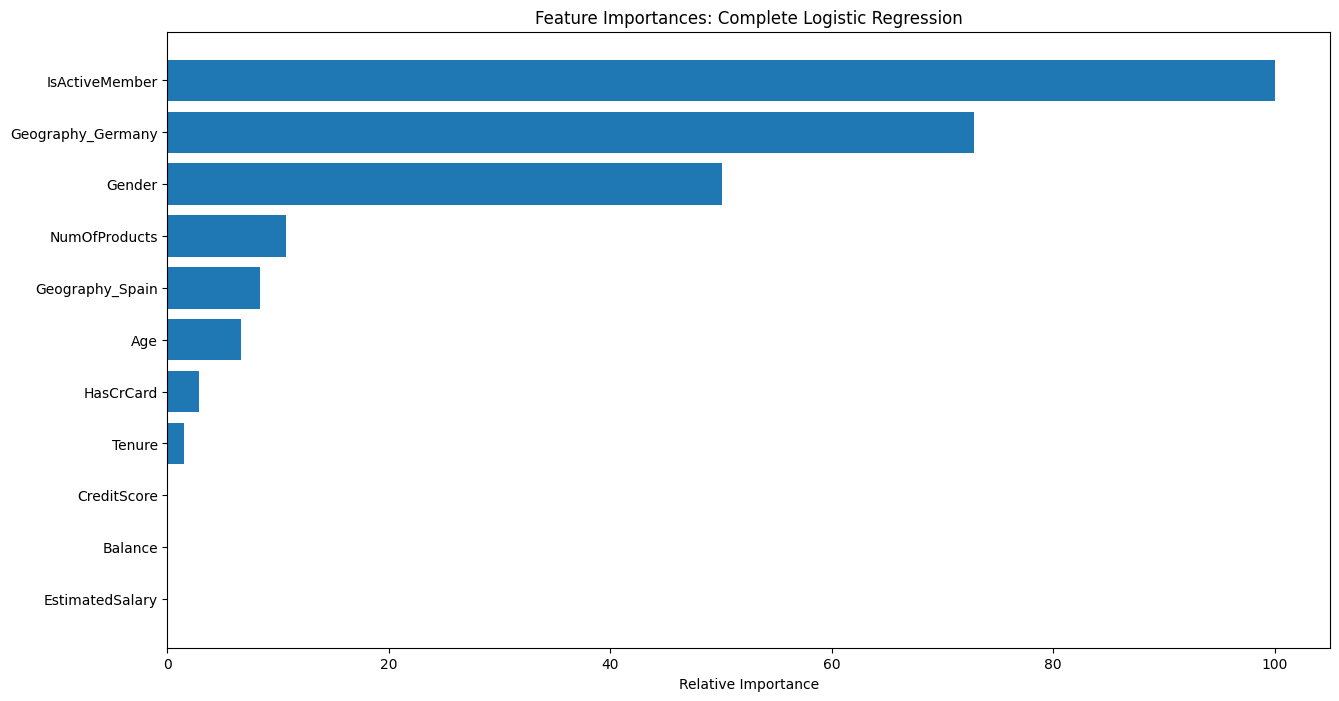

In [198]:
model = LogisticRegression(**model_LR.best_params_)
model.fit(train[features], train[target])

importances = abs(model.coef_[0])
importances = 100.0 * (importances / importances.max())
indices = np.argsort(importances)

plt.figure(figsize = (15, 8))
plt.title('Feature Importances: Complete Logistic Regression')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Now, let's compute the predictions for the best set of parameters:

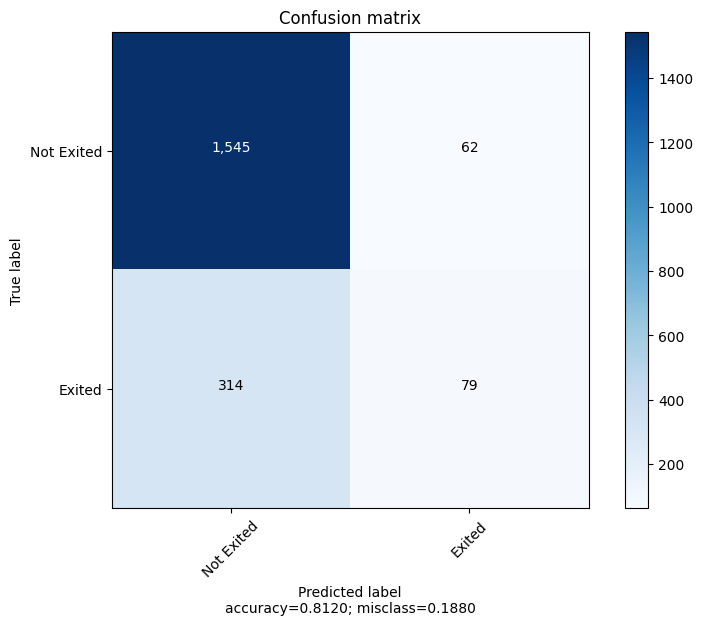

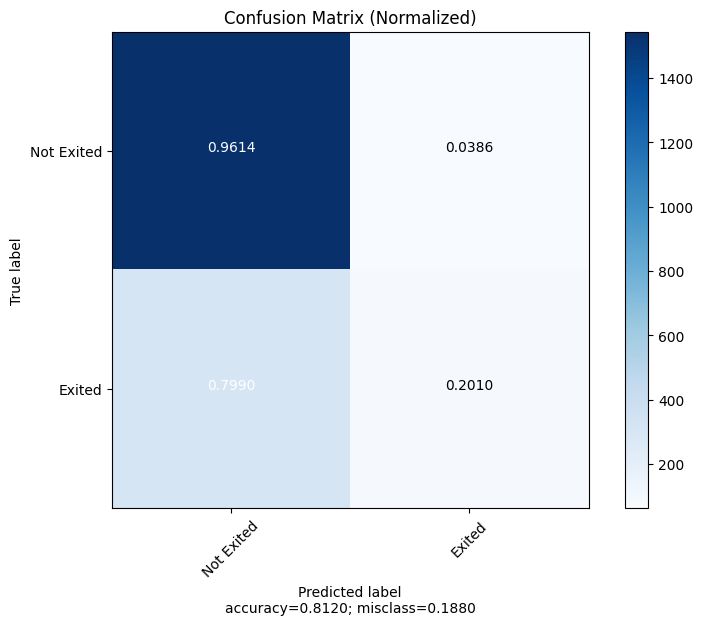

,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Logistic Regression,no,0.812,0.581218,0.778563,0.831092,0.961419,0.891518,0.560284,0.201018,0.29588


In [199]:
pred = model_LR.predict(test[features])
predp = model_LR.predict_proba(test[features])[:,1]

cm = confusion_matrix(test[target], pred)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')

table_of_models = classification_report_to_dataframe(test[target], pred, predp, model_name = 'Logistic Regression')
table_of_models

####  MLP: Multi Layers Perceptron

Now, let's enter in the `Neural Networks` domain, by doing predictions using the Sklear Multi-Layer Perceptron (MLP) Classifier.

In [200]:
s = len(features)
parameters = {'hidden_layer_sizes': [(s,),
                                     (s,)*2,
                                     (s,)*4,
                                     (s,)*6],
              'solver': ['lbfgs', 'adam'],
              'alpha': [0, 0.01, 0.1, 1, 10]}
MLP = MLPClassifier()
model_MLP = GridSearchCV(MLP, parameters, cv = 5, n_jobs = 10, verbose = 1).fit(train[features], train[target])
pd.DataFrame(model_MLP.cv_results_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_hidden_layer_sizes,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.423869,0.186367,0.004785,0.001164,0.00,"(11,)",lbfgs,"{'alpha': 0, 'hidden_layer_sizes': (11,), 'sol...",0.538125,0.794375,0.554375,0.474375,0.794375,0.631125,0.135949,27
1,2.057098,1.065274,0.005786,0.001466,0.00,"(11,)",adam,"{'alpha': 0, 'hidden_layer_sizes': (11,), 'sol...",0.747500,0.778750,0.467500,0.368750,0.789375,0.630375,0.176630,28
2,0.669607,0.260677,0.005989,0.001997,0.00,"(11, 11)",lbfgs,"{'alpha': 0, 'hidden_layer_sizes': (11, 11), '...",0.205000,0.794375,0.794375,0.794375,0.794375,0.676500,0.235750,16
3,3.947643,1.379390,0.019948,0.029926,0.00,"(11, 11)",adam,"{'alpha': 0, 'hidden_layer_sizes': (11, 11), '...",0.785000,0.720625,0.771250,0.735000,0.790625,0.760500,0.027798,6
4,1.489217,0.455501,0.004987,0.001545,0.00,"(11, 11, 11, 11)",lbfgs,"{'alpha': 0, 'hidden_layer_sizes': (11, 11, 11...",0.795000,0.794375,0.205625,0.790000,0.794375,0.675875,0.235132,17
5,4.829286,0.744263,0.004635,0.000437,0.00,"(11, 11, 11, 11)",adam,"{'alpha': 0, 'hidden_layer_sizes': (11, 11, 11...",0.755000,0.788125,0.532500,0.778125,0.790000,0.728750,0.098912,10
6,1.181440,0.044256,0.037301,0.039019,0.00,"(11, 11, 11, 11, 11, 11)",lbfgs,"{'alpha': 0, 'hidden_layer_sizes': (11, 11, 11...",0.795000,0.526250,0.794375,0.205625,0.794375,0.623125,0.233189,30
7,6.564247,3.259761,0.007181,0.004010,0.00,"(11, 11, 11, 11, 11, 11)",adam,"{'alpha': 0, 'hidden_layer_sizes': (11, 11, 11...",0.794375,0.658125,0.784375,0.477500,0.753125,0.693500,0.118234,15
8,0.315356,0.112954,0.005588,0.001494,0.01,"(11,)",lbfgs,"{'alpha': 0.01, 'hidden_layer_sizes': (11,), '...",0.456875,0.793750,0.730000,0.205625,0.703750,0.578000,0.218540,33
9,1.579576,0.696907,0.005784,0.001163,0.01,"(11,)",adam,"{'alpha': 0.01, 'hidden_layer_sizes': (11,), '...",0.417500,0.477500,0.472500,0.685625,0.790625,0.568750,0.143774,35


In [201]:
print(model_MLP.best_params_)

{'alpha': 10, 'hidden_layer_sizes': (11, 11, 11, 11), 'solver': 'lbfgs'}


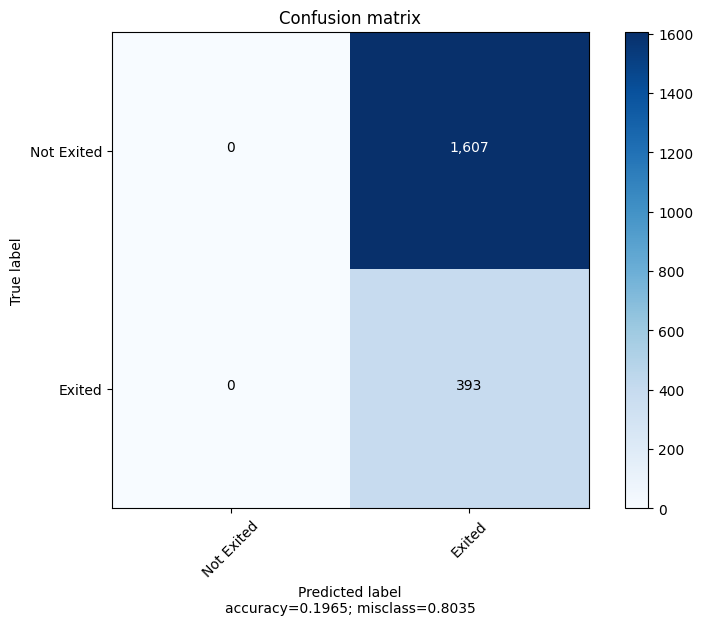

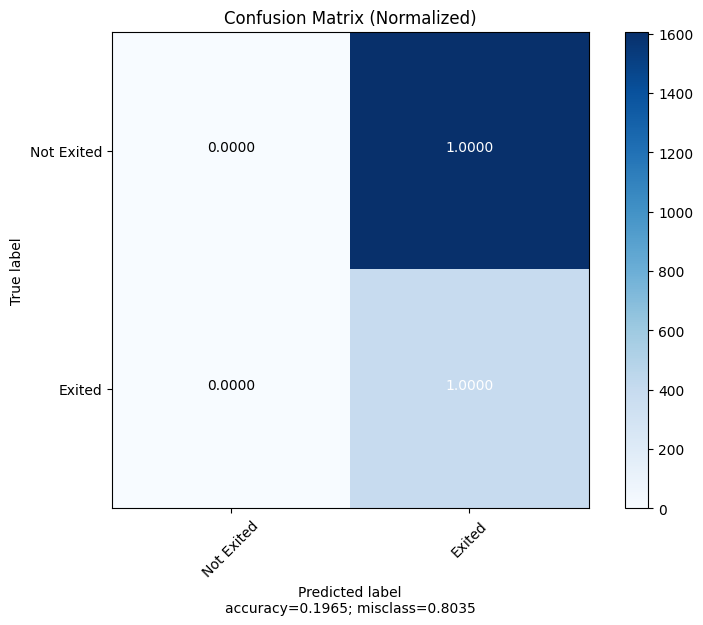

,Model,Balanced,Accuracy,Balanced_Accuracy,AUC,precision_0,recall_0,f1-score_0,precision_1,recall_1,f1-score_1
0,Multi-Layer Perceptron (MLP),no,0.1965,0.5,0.5,0.0,0.0,0.0,0.1965,1.0,0.328458


In [202]:
pred = model_MLP.predict(test[features])
predp = model_MLP.predict_proba(test[features])[:,1]

cm = confusion_matrix(test[target], pred)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = False)
plot_confusion_matrix(cm, target_names = ['Not Exited', 'Exited'], normalize = True, title = 'Confusion Matrix (Normalized)')

temp = classification_report_to_dataframe(test[target], pred, predp, model_name = 'Multi-Layer Perceptron (MLP)')
temp

### 3. Create a simple prediction model using the following features:

#### Credit Score

In [ ]:


# Selecting the relevant features and the target
features = ['CreditScore']
X = data[features]
y = data['Exited']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize the model (You can try Logistic Regression or Random Forest)
model = RandomForestClassifier(random_state=42)
# model = LogisticRegression(random_state=42) # Uncomment to use Logistic Regression

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.8005
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.99      0.89      1607
           1       0.31      0.01      0.02       393

    accuracy                           0.80      2000
   macro avg       0.56      0.50      0.46      2000
weighted avg       0.71      0.80      0.72      2000

Confusion Matrix:
 [[1596   11]
 [ 388    5]]


### Age


In [146]:
X= data[['Age']]  # Feature
y= data['Exited']  # Target (0 or 1 for classification)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7823333333333333
Confusion Matrix:
 [[2324   92]
 [ 561   23]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.96      0.88      2416
           1       0.20      0.04      0.07       584

    accuracy                           0.78      3000
   macro avg       0.50      0.50      0.47      3000
weighted avg       0.69      0.78      0.72      3000



### Balance

In [147]:
X= data[['Balance']]  # Feature
y= data['Exited']  # Target (0 or 1 for classification)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8053333333333333
Confusion Matrix:
 [[2416    0]
 [ 584    0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      1.00      0.89      2416
           1       0.00      0.00      0.00       584

    accuracy                           0.81      3000
   macro avg       0.40      0.50      0.45      3000
weighted avg       0.65      0.81      0.72      3000



### Number of prodcut

In [148]:
X= data[['NumOfProducts']]  # Feature
y= data['Exited']  # Target (0 or 1 for classification)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8053333333333333
Confusion Matrix:
 [[2416    0]
 [ 584    0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      1.00      0.89      2416
           1       0.00      0.00      0.00       584

    accuracy                           0.81      3000
   macro avg       0.40      0.50      0.45      3000
weighted avg       0.65      0.81      0.72      3000



### Active member status

In [149]:
X= data[['IsActiveMember']]  # Feature
y= data['Exited']  # Target (0 or 1 for classification)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8053333333333333
Confusion Matrix:
 [[2416    0]
 [ 584    0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      1.00      0.89      2416
           1       0.00      0.00      0.00       584

    accuracy                           0.81      3000
   macro avg       0.40      0.50      0.45      3000
weighted avg       0.65      0.81      0.72      3000



 ## A summary of findings including:


### Customer demographics analysis


### Churn Rate by Geography
This barplot will show how churn rates differ across the countries in the Geography column.

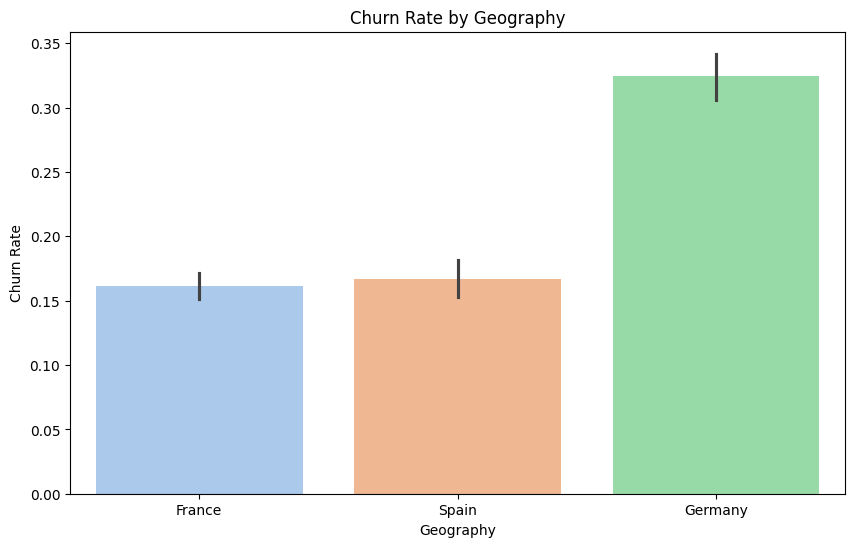

In [8]:
# Plotting churn rate by Geography
plt.figure(figsize=(10, 6))
sns.barplot(data=data, x='Geography', y='Exited', palette='pastel')
plt.title('Churn Rate by Geography')
plt.xlabel('Geography')
plt.ylabel('Churn Rate')
plt.show()

###  Gender Distribution in the Dataset
Number of Males is greater than  females represented in the dataset.

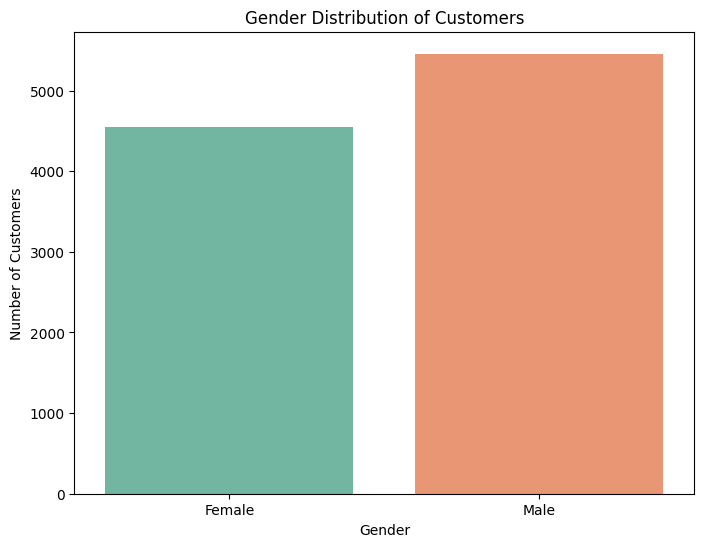

In [17]:
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='Gender', palette='Set2')
plt.title('Gender Distribution of Customers')
plt.xlabel('Gender')
plt.ylabel('Number of Customers')
plt.show()

 ### Churn Rate for Older Customers (Above 50 years)

 	Older customers (above 50 years) exhibit a significantly higher churn rate.

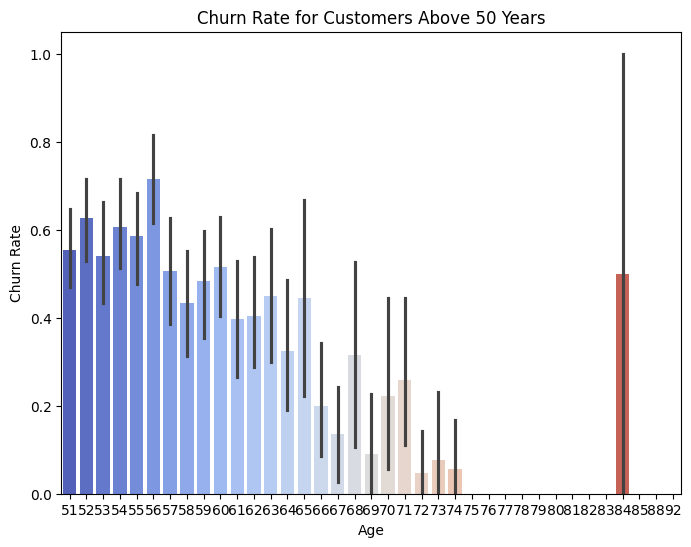

In [19]:
older_customers = data[data['Age'] > 50]

# Plotting the churn rate for customers above 50
plt.figure(figsize=(8, 6))
sns.barplot(data=older_customers, x='Age', y='Exited', palette='coolwarm')
plt.title('Churn Rate for Customers Above 50 Years')
plt.xlabel('Age')
plt.ylabel('Churn Rate')
plt.show()

### Churn Rate for Younger Customers (Below 30 years)
Younger customers (below 30 years) are less likely to churn.

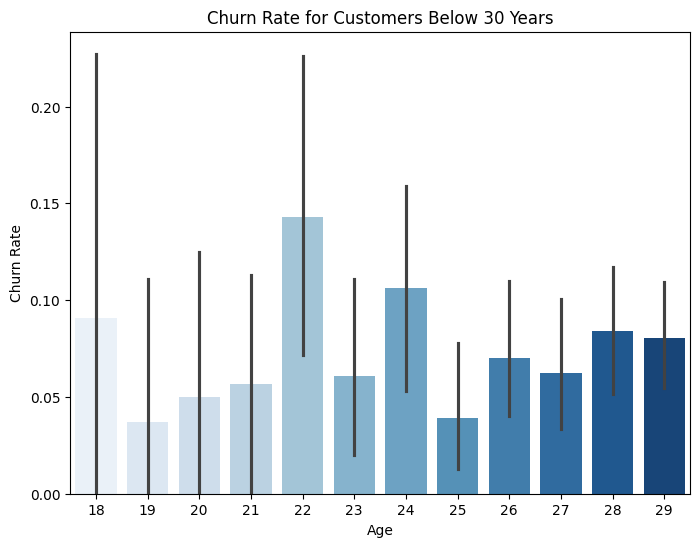

In [20]:
younger_customers = data[data['Age'] < 30]

# Plotting the churn rate for customers below 30
plt.figure(figsize=(8, 6))
sns.barplot(data=younger_customers, x='Age', y='Exited', palette='Blues')
plt.title('Churn Rate for Customers Below 30 Years')
plt.xlabel('Age')
plt.ylabel('Churn Rate')
plt.show()

### Churn Rate by Gender
Females show a slightly higher churn rate compared to males.

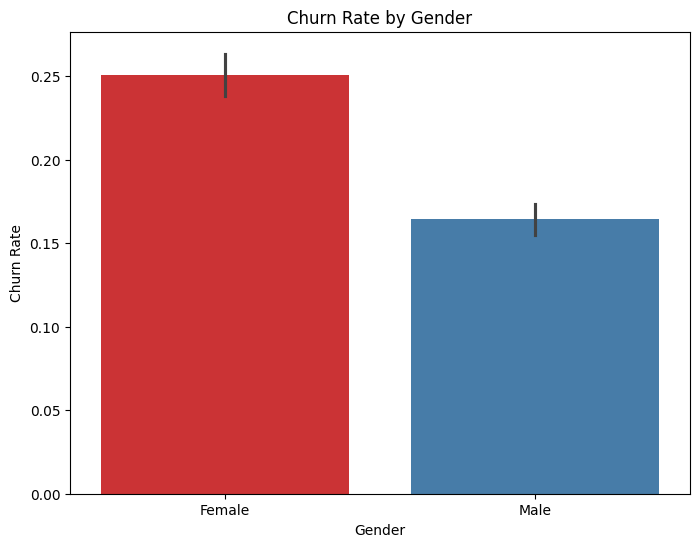

In [18]:
plt.figure(figsize=(8, 6))
sns.barplot(data=data, x='Gender', y='Exited', palette='Set1')
plt.title('Churn Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Churn Rate')
plt.show()

### Balance:
Customers with very high balances are more likely to churn, possibly indicating dissatisfaction despite financial security.


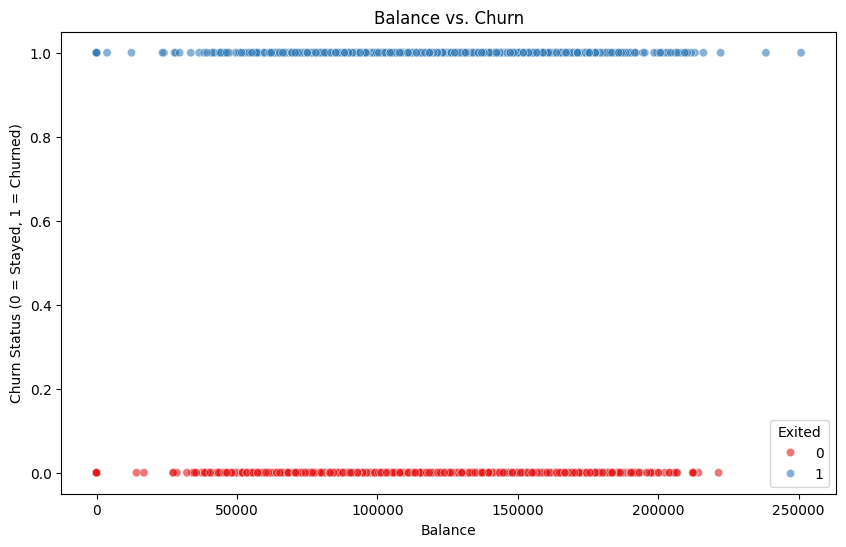

In [23]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Balance', y='Exited', hue='Exited', palette='Set1', alpha=0.6)
plt.title('Balance vs. Churn')
plt.xlabel('Balance')
plt.ylabel('Churn Status (0 = Stayed, 1 = Churned)')
plt.show()

### Number of Products:
Customers with only 1 product are more likely to churn, while those with 3 or more products show a much lower churn rate.


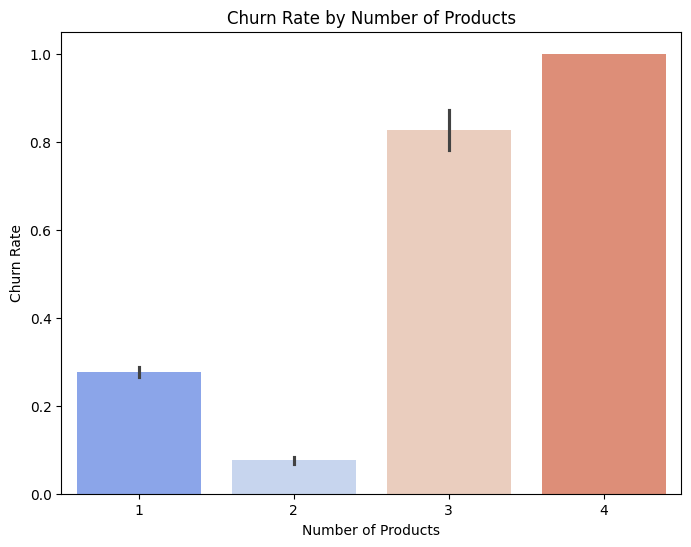

In [24]:
plt.figure(figsize=(8, 6))
sns.barplot(data=data, x='NumOfProducts', y='Exited', palette='coolwarm')
plt.title('Churn Rate by Number of Products')
plt.xlabel('Number of Products')
plt.ylabel('Churn Rate')
plt.show()

### Activity Level:
o	Active customers churn less frequently than inactive customers.


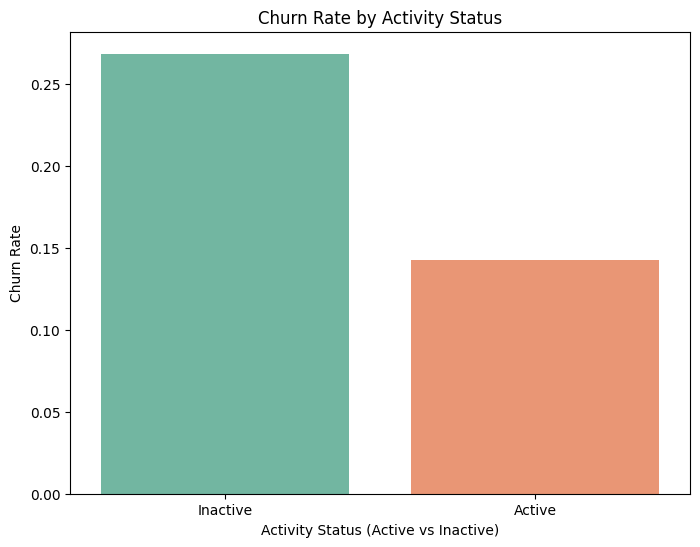

In [25]:
churn_rate_by_activity = data.groupby('IsActiveMember')['Exited'].mean().reset_index()

# Map the 'IsActiveMember' column to a more understandable label
churn_rate_by_activity['Activity_Status'] = churn_rate_by_activity['IsActiveMember'].map({1: 'Active', 0: 'Inactive'})

# Plotting the churn rate for active vs inactive customers
plt.figure(figsize=(8, 6))
sns.barplot(data=churn_rate_by_activity, x='Activity_Status', y='Exited', palette='Set2')
plt.title('Churn Rate by Activity Status')
plt.xlabel('Activity Status (Active vs Inactive)')
plt.ylabel('Churn Rate')
plt.show()

### Geography Distribution:
Customers are primarily from France, followed by Germany and Spain.


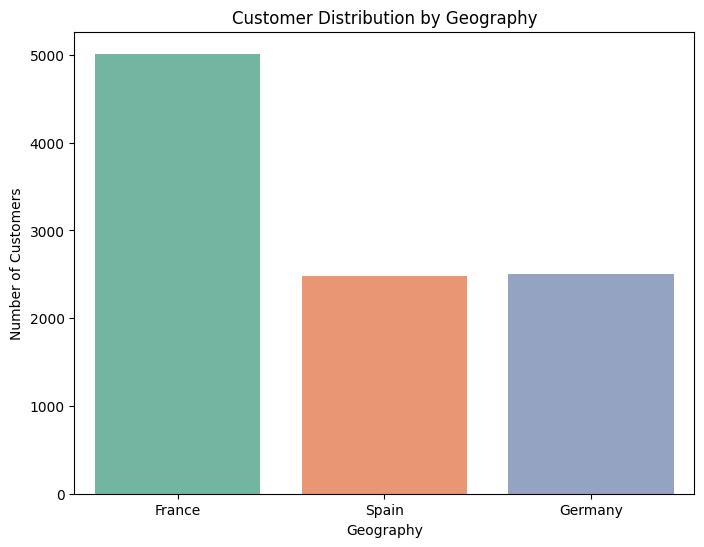

In [16]:
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='Geography', palette='Set2')
plt.title('Customer Distribution by Geography')
plt.xlabel('Geography')
plt.ylabel('Number of Customers')
plt.show()

### 2. Churn Rate Patterns

### Balance Distribution by Churn Status
This boxplot will show how account balance varies between customers who churned (1) and those who stayed (0).

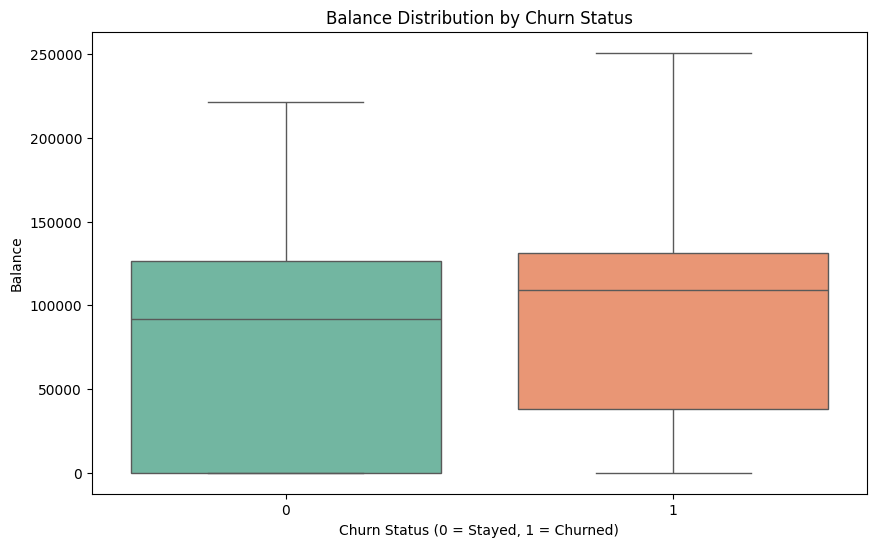

In [9]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='Exited', y='Balance', palette='Set2')
plt.title('Balance Distribution by Churn Status')
plt.xlabel('Churn Status (0 = Stayed, 1 = Churned)')
plt.ylabel('Balance')
plt.show()

### 3. Risk Factors for Customer Churn
Risk Factors: Number of Products vs. Credit Score

This boxplot will show the distribution of Credit Score across different NumOfProducts.

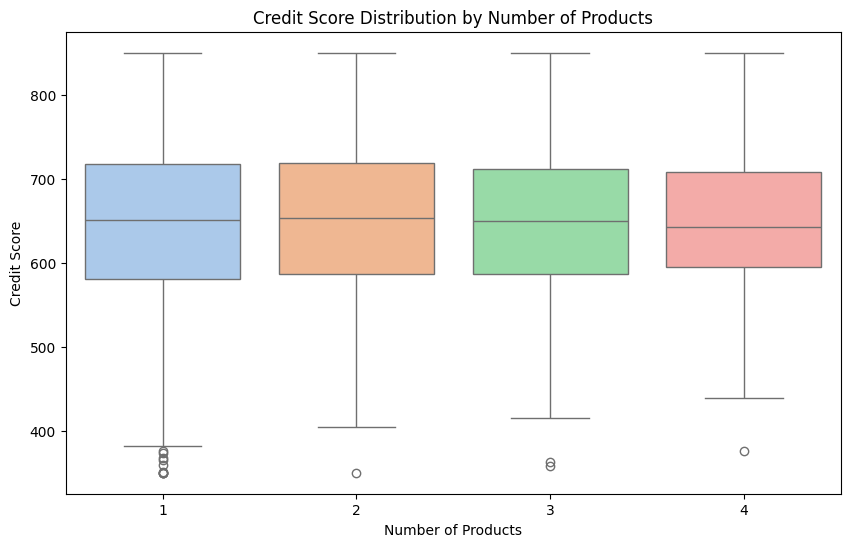

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='NumOfProducts', y='CreditScore', palette='pastel')
plt.title('Credit Score Distribution by Number of Products')
plt.xlabel('Number of Products')
plt.ylabel('Credit Score')
plt.show()

### Risk Factors: Churn Rate by Activity Status
This barplot will show how churn rates vary between active and inactive customers.

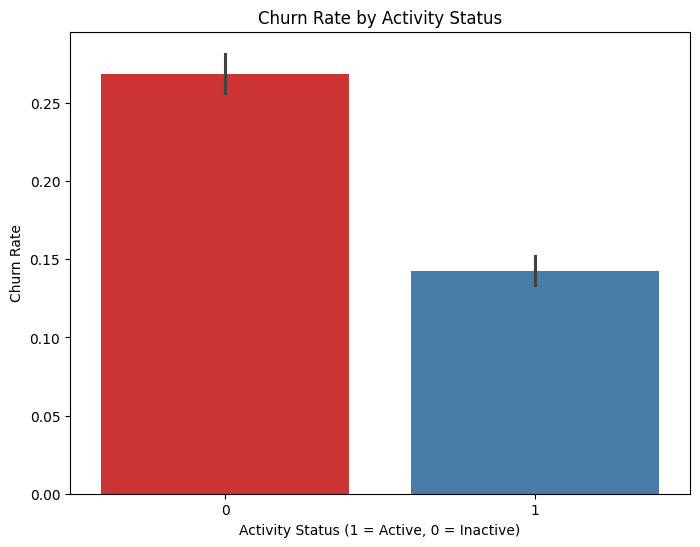

In [12]:
plt.figure(figsize=(8, 6))
sns.barplot(data=data, x='IsActiveMember', y='Exited', palette='Set1')
plt.title('Churn Rate by Activity Status')
plt.xlabel('Activity Status (1 = Active, 0 = Inactive)')
plt.ylabel('Churn Rate')
plt.show()

### 4. Recommendations for Reducing Churn
Churn Rate by Number of Products
This barplot will show how churn rates vary with the number of products each customer holds.

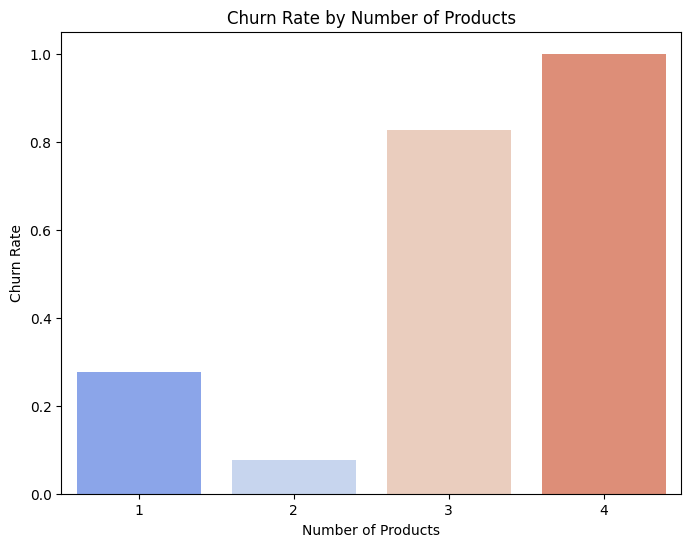

In [13]:
prod_churn = data.groupby('NumOfProducts')['Exited'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(data=prod_churn, x='NumOfProducts', y='Exited', palette='coolwarm')
plt.title('Churn Rate by Number of Products')
plt.xlabel('Number of Products')
plt.ylabel('Churn Rate')
plt.show()

### 5. General Correlation between Features
Correlation Heatmap for Numerical Features
This heatmap will show the correlation between numerical features such as CreditScore, Age, Tenure, Balance, etc.

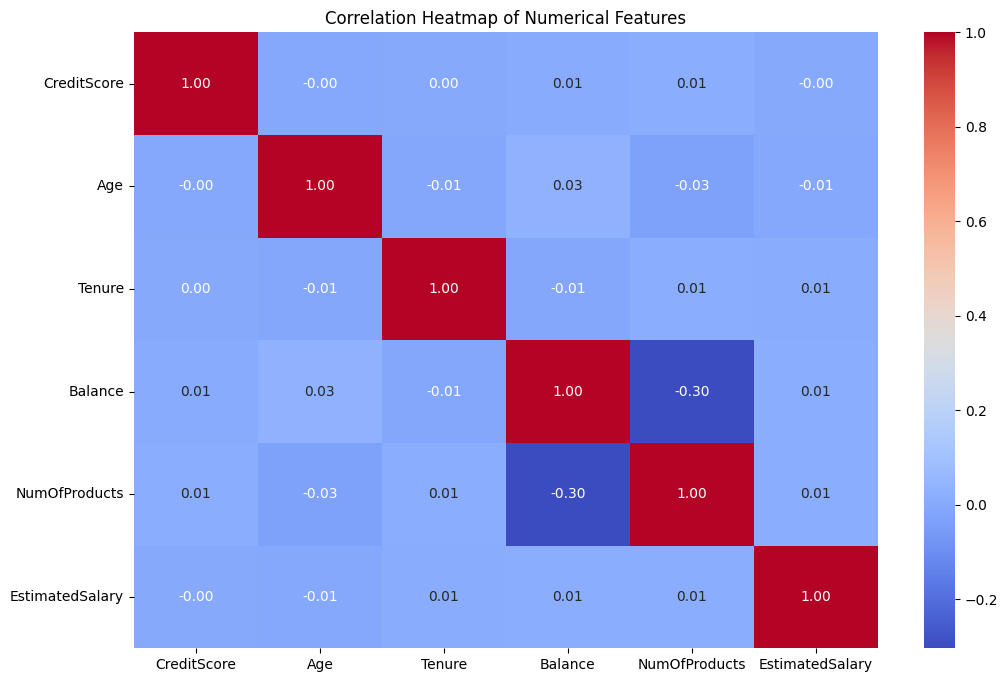

In [14]:
plt.figure(figsize=(12, 8))
numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
sns.heatmap(data[numeric_features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

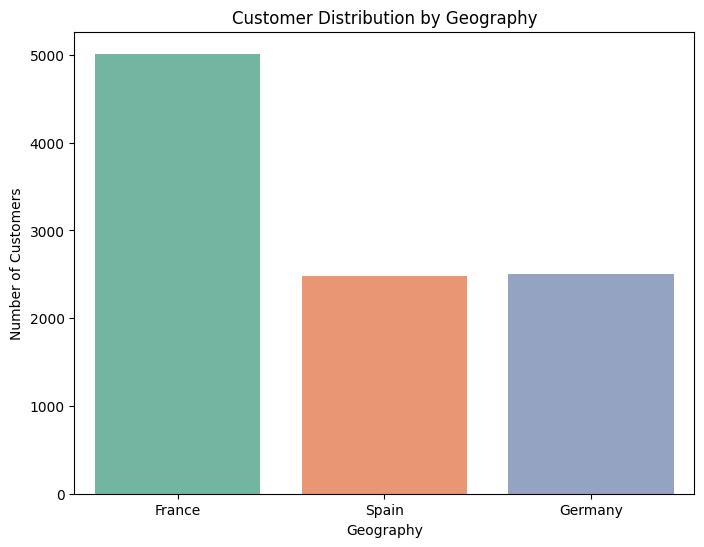